# Modeling

In this notebook, I aim to first evaluate different models. After I determine the best model for this problem, I will optimize that model, and then interpret the results.

**Please Note: Restarting this notebook will cause errors in the code since all the data is not stored locally.**

## Contents

[Finding Optimal Model](#Finding-Optimal-Model)<br>
[Optimizing Best Model](#Optimizing-Best-Model)<br>
[Interpretting Results](#Interpretting-Results)

In [1]:
import pandas as pd
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999999)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
fs = s3fs.S3FileSystem(anon=False,key='AWS Key',secret='AWS SECRET KEY')

key = 'nfl_play_by_play_with_weather_model.csv'
bucket = 'nfl-play-by-play-capstone'

df = pd.read_csv(fs.open('{}/{}'.format(bucket, key),
                         mode='rb')).drop(columns=['Unnamed: 0'])

### Finding Optimal Model

In this section I evaluate the performance of various models in order to choose the best model available. It should be noted that I chose to use the default model or in some cases where there is no true default (i.e. Neural Network) I chose to use a very simple model. I could have spent time optimizing each model and then comparing their results. Instead I chose to compare their baseline results, choose the best performer, and then optimize that model.

The first step in evaluating models is determining what metric I want to optimize. I chose accuracy because our classes are not very unbalanced, and the cost of false negatives and false positives are fairly equal in my mind. If the classification was something along the lines of fraud detection where the cost of a false negative is much higher than a false positive, I would want to optimize for something like AUC. Here is a great resource that explains the difference between the two: [AUC vs. Accuracy](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy). <br>

Now that I have chosen accuracy, we need to take a look at the baseline accuracy that we need to beat.

In [3]:
df['effective_pass'].mean(), df['effective_run'].mean()

(0.5785119585892918, 0.42148804141070817)

The baseline is 57.8% since the majority class (pass) occurs 57.8% of the time in our dataset. The next step is prepare the indepedent (X) and dependent variables (y). I will split the data into a training and testing set in order to evaluate the models' performance on unseen data (test data). We are going to be predicting whether or not something is a run (positive case).

In [4]:
X = df.drop(columns=['effective_run','effective_pass','posteam','defteam'])
y = df['effective_run']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

The next step is to create a function that will run different models and return their performance. I chose to evaluate these models: RandomForestClassifier, ExtraTreesClassifier, LogisticRegression, GaussianNB, XGBoost, and a simple neural network.

In [5]:
def classification_models(X_train, X_test, y_train, y_test):
    
    models = []
    for i in [RandomForestClassifier,ExtraTreesClassifier,LogisticRegression,GaussianNB]:
        print(f"Fitting {i} ...")
        model_dict = {}
        model = i()
        model.fit(X_train,y_train)
        model_dict['Model'] = i
        model_dict['Train Score'] = model.score(X_train,y_train)
        model_dict['Test Score'] = model.score(X_test, y_test)
        models.append(model_dict)
    
    for i in [1]:
        print("Fitting XGBoost ...")
        model_dict = {}
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric=["error"],
                                      silent=1)
        xgb_model.fit(X_train, y_train, early_stopping_rounds=5,eval_set=[(X_test, y_test)])
        model_dict['Model'] = 'XGBoost'
        model_dict['Train Score'] = xgb_model.score(X_train,y_train)
        model_dict['Test Score'] = xgb_model.score(X_test, y_test)
        models.append(model_dict)
    
    for i in [1]:
        model_dict = {}
        print("Fitting Neural Network...")
        ss = StandardScaler()
        X_train_sc = ss.fit_transform(X_train)
        X_test_sc = ss.transform(X_test)
        nn = Sequential()
        nn.add(Dense(32,activation='relu',input_shape = (X_train_sc.shape[1],)))
        nn.add(Dense(1,activation='sigmoid'))
        nn.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy'])
        nn.fit(X_train_sc,y_train,epochs=50,batch_size=256,validation_data=(X_test_sc,y_test),verbose=0)
        model_dict['Model'] = 'Neural Network'
        model_dict['Train Score'] = accuracy_score(y_train, nn.predict_classes(X_train_sc))
        model_dict['Test Score'] = accuracy_score(y_test, nn.predict_classes(X_test_sc))
        models.append(model_dict)
    
    return pd.DataFrame(models).sort_values(by='Test Score',ascending=False)

The function does take a few minutes to run, so I commented out the code below and saved the output in the datasets folder.

```python 
models = classification_models(X_train, X_test, y_train, y_test)
models.to_csv('../datasets/model_performance.csv',index=False)
```

In [6]:
pd.read_csv('../datasets/model_performance.csv')

,Model,Test Score,Train Score
0,XGBoost,0.696494,0.701464
1,Neural Network,0.694324,0.712636
2,<class 'sklearn.ensemble.forest.RandomForestCl...,0.676250,0.984213
3,<class 'sklearn.ensemble.forest.ExtraTreesClas...,0.669215,0.999992
4,<class 'sklearn.linear_model.logistic.Logistic...,0.659412,0.664003
5,<class 'sklearn.naive_bayes.GaussianNB'>,0.625447,0.625419


The XGBoost and Neural Network seemed to perform the best of the 6 models I chose. The Neural Network seems a little more overfit when comparing training and testing scores. I chose to implement and optimize the XGBoost model for interpretability and it's slightly better performance (although performance on all of these could most likely be improved with GridSearching hyperparameters).

### Optimizing Best Model

In this section I ran a gridsearch on a few hyperparameters for the XGBoost model. I chose to look at subsample and max_depth. Their definitions can be found in the XGBoost [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html). Decreasing subsample can make the model less overfit, and increasing max depth can make the model overfit, so gridsearching over the two seemed to create a balance.

This code is commented out because it takes approximately and hour to run on this particular dataset.

```python 
xgb_params = {
        'subsample': [0.5, 0.7, 1.0],
        'max_depth': [6, 8, 10, 12],
}

xgb_gridsearch = GridSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric = ['error']),
    xgb_params,
    cv=3,
    n_jobs=8,
    verbose=1,
    return_train_score=False
)

xgb_gridsearch.fit(X_train, y_train,early_stopping_rounds=5,eval_set=[(X_test, y_test)])

print(xgb_gridsearch.best_score_)
print(xgb_gridsearch.best_params_)
```

**Results:**<br>
61 minutes to run<br>
Best Score: 0.7078127533604693<br>
Best Parameters: {'max_depth': 8, 'subsample': 0.7}<br>

I will then fit the model with the best parameters.

In [7]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, 
                              eval_metric=["error"], max_depth = 8, subsample=0.7)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5,eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

[0]	validation_0-error:0.308433
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.307922
[2]	validation_0-error:0.305203
[3]	validation_0-error:0.305552
[4]	validation_0-error:0.304267
[5]	validation_0-error:0.303556
[6]	validation_0-error:0.303332
[7]	validation_0-error:0.302558
[8]	validation_0-error:0.302209
[9]	validation_0-error:0.300775
[10]	validation_0-error:0.300725
[11]	validation_0-error:0.300388
[12]	validation_0-error:0.299964
[13]	validation_0-error:0.299415
[14]	validation_0-error:0.29919
[15]	validation_0-error:0.298879
[16]	validation_0-error:0.298679
[17]	validation_0-error:0.298617
[18]	validation_0-error:0.298193
[19]	validation_0-error:0.298155
[20]	validation_0-error:0.297981
[21]	validation_0-error:0.297856
[22]	validation_0-error:0.297694
[23]	validation_0-error:0.297282
[24]	validation_0-error:0.296846
[25]	validation_0-error:0.296621
[26]	validation_0-error:0.296409
[27]	validation_0-error:0.296434
[28]	validation_0-erro

### Interpretting Results

In this section I aim to evaluate the overall results, and then dig deeper to see how the model's accuracy changed given the play circumstances (down, quarter, distance, team, etc.).

In [8]:
print(f'Test Accuracy Score: {xgb_model.score(X_test,y_test)}')
print(f'Train Accuracy Score: {xgb_model.score(X_train,y_train)}')

Test Accuracy Score: 0.7062227932096841
Train Accuracy Score: 0.7205020850916983


As you can see, the accuracy rate of 70.6% is well above the baseline of 57.8%, but there is probably still room for improvement.

In [9]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'Specificity: {round(tn/(tn+fp),4)}')
print(f'Sensitivity/Recall: {round(tp/(tp+fn),4)}')
pd.DataFrame(confusion_matrix(y_test, y_pred), 
                   index=['True Pass', 'True Run'], columns=['Pred Pass', ' Pred Run'])

Specificity: 0.7277
Sensitivity/Recall: 0.6767


,Pred Pass,Pred Run
True Pass,33760,12630
True Run,10923,22860


Since our specificity is higher than our sensitivity, we are better able to predict pass (negative case) than run (positive case). Now let's take a look at the importance features in this tree-based model.

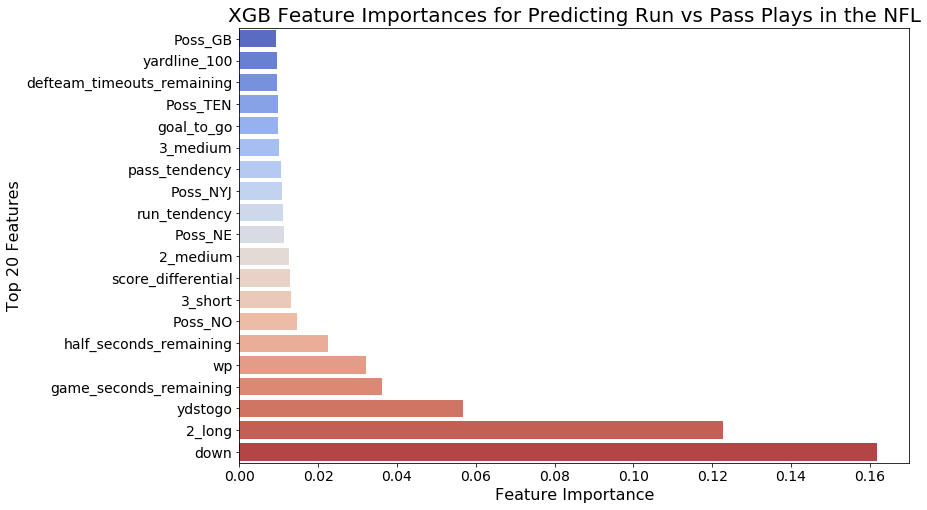

In [10]:
feature_importances = pd.DataFrame(zip(X_train.columns,xgb_model.feature_importances_))
feature_importances.rename(columns={0:'Feature',1:'Feature Importance'},inplace=True)
top_features = feature_importances.sort_values(by=['Feature Importance']).tail(20)
plt.figure(figsize=(12,8))
sns.barplot(x=top_features['Feature Importance'],y=top_features['Feature'],palette='coolwarm')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Top 20 Features',fontsize=16)
plt.xlabel('Feature Importance',fontsize=16)
plt.title('XGB Feature Importances for Predicting Run vs Pass Plays in the NFL',fontsize=20);

Down was by far the most important feature in predicting play type, but things like yards to go and game seconds remaining were also very important. The tendency of the possession team (run or pass) also proved to be a helpful feature to add.

Now let's dive deeper to see what types of scenarios resulted in a higher accuracy than others.

In [11]:
X_test['pred'] = y_pred
X_test['true'] = y_test

test_mask = [X_test['pred'] == X_test['true']] 

X_test['correct'] = np.select(test_mask, [1], 0)

baselines = []
for i in list(df.groupby(['down'])[['effective_run']].mean().values):
    if i[0] < 0.5:
        baselines.append(np.round((1-i[0]),6))
    else:
        baselines.append(np.round(i[0],6))


down = X_test.groupby('down')[['correct']].mean()
down['baseline'] = baselines
down

,correct,baseline
down,,
1.0,0.648432,0.516141
2.0,0.685490,0.573104
3.0,0.856127,0.785627
4.0,0.814092,0.632909


Accuracy was lowest on 1st down, but highest on 3rd down. 3rd down is arguably the most important down because most teams will not go on an average 4th down. A big third down stop can really change the momentum of the game in favor of the defensive team, so I am very happy with this result. That being said, teams do pass on 78% of third down plays, so 86% accuracy is better, but not hugely better.

Now let's look at down and yardstogo segments. I am going to use the same code that I used in the feature engineering notebook to recreate the distance feature that I dropped.

In [12]:
test_mask = [X_test['ydstogo'].between(0,3), X_test['ydstogo'].between(4,7), X_test['ydstogo'].between(8,100)]
df_mask = [df['ydstogo'].between(0,3), df['ydstogo'].between(4,7), df['ydstogo'].between(8,100)]
values = ['Short','Medium','Long']
X_test['distance'] = np.select(test_mask, values, 0)
df['distance'] = np.select(df_mask,values,0)

baselines = []
for i in list(df.groupby(['down','distance'])[['effective_run']].mean().values):
    if i[0] < 0.5:
        baselines.append(np.round((1-i[0]),6))
    else:
        baselines.append(np.round(i[0],6))

down_distance =  X_test.groupby(['down','distance'])[['correct']].agg(['mean','count'])
down_distance['baseline'] = baselines
down_distance

correct         baseline
                   mean  count          
down distance                           
1.0  Long      0.646693  33928  0.510238
     Medium    0.661692   1005  0.588264
     Short     0.714080    696  0.695621
2.0  Long      0.700048  14479  0.648864
     Medium    0.633553   8184  0.537981
     Short     0.737597   4112  0.630200
3.0  Long      0.892279   6981  0.863919
     Medium    0.895158   5246  0.878845
     Short     0.751375   4364  0.551924
4.0  Long      0.918288    257  0.886386
     Medium    0.860558    251  0.862450
     Short     0.756716    670  0.548088

You can see that 4th and long has the best accuracy rate, but that makes sense because most teams wouldn't pass or run on 4th and long - they would most likely punt. But these plays (only 257 in the entire dataframe) are most likely when a team is down by a lot and desperate for points. 3rd down still proved to be an accurate down, but the 3rd and short situations were harder to predict than short and long/medium. <br><br>
When comparing the the baseline accuracies, the model improved every situation except 4th and Medium. Given that this scenario only occured 251 times with a pass or run, I am okay with this. 3rd and short was actually the largest marginal improvement in accuracy.

Now let's look at how the accuracy changes given what quarter the play occurs in.

In [13]:
X_test.groupby('qtr')[['correct']].mean().join(1-df.groupby(['qtr'])[['effective_run']].mean()).rename(columns={
    'effective_run':'baseline'})

,correct,baseline
qtr,,
1.0,0.644448,0.538603
2.0,0.703489,0.615784
3.0,0.676504,0.561167
4.0,0.785227,0.589670


The model is better at predicting play type in the second quarter and fourth quarter.

Now let's take a look at how the model performs given a possession team.

In [14]:
X_test =  X_test.join(df[['posteam','defteam']])

In [15]:
X_test.groupby('posteam')[['correct']].mean().sort_values(by='correct',ascending=False).head()

,correct
posteam,
LAC,0.742489
BAL,0.731520
SD,0.731244
DAL,0.728778
ARI,0.728124


In [16]:
X_test.groupby('posteam')[['correct']].mean().sort_values(by='correct',ascending=False).tail()

,correct
posteam,
CAR,0.688880
PHI,0.678005
GB,0.674149
SF,0.673503
KC,0.670532


The LA Chargers/SD Chargers seem to be the most predictable, while the Kansas City Chiefs seem to be the most unpredictable.

Overall, the model was able to achieve a 70.6% accuracy rate which is similar to other models I have seen out there. There is most likely room for improvement if i were to use more/different features.